In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from iflow.dataset import gen_cycle_dataset
from data.human_robot_interaction_data.read_hh_hr_data import read_data
#from iflow.dataset.iros_dataset import IROS

import torch
import torch.optim as optim
from iflow.dataset import drums_dataset, gen_cycle_dataset, hr_cycle_dataset, hr_vel_cycle_dataset
from torch.utils.data import DataLoader
from iflow import model
from iflow.trainers import cycle_dynamics_train
from iflow.utils.generic import to_torch

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as spio
from iflow.dataset.generic_dataset import Dataset

from iflow.visualization import visualize_vector_field, visualize_trajectories
from iflow.test_measures import iros_evaluation
from iflow.visualization import visualize_2d_generated_trj, visualize_latent_distribution
from iflow.test_measures.log_likelihood import cycle_log_likelihood

In [2]:
# model parameters
depth = 3
## training variables ##
batch_size = 100
nr_epochs = 10000

# downsampling parameters
stepsize = 1
cutoff = 400
offset = 140

device = torch.device('cpu')

def main_layer(dim):
    return  model.ResNetCouplingLayer(dim)

def create_flow_seq(dim, depth):
    chain = []
    for i in range(depth):
        chain.append(main_layer(dim))
        chain.append(model.Permutation(torch.tensor([1,0], dtype=torch.int32),1))
        chain.append(model.LULinear(dim))
    chain.append(main_layer(dim))
    return model.SequentialFlow(chain)

def load_data(data, segments, stepsize, cutoff, offset):
    trajs = [data[s[0]:s[1], :, :] for s in segments]
    trajs = np.array([a[::stepsize,:,:][offset:cutoff] for a in trajs])
    trajs = trajs.reshape(*trajs.shape[:-2], -1)[:, :, -2:]
    return trajs

In [3]:
data_name = "rocket"
data_p1_p, data_p1_q, names_p1, times_p1 = read_data(f'data/human_robot_interaction_data/hh/p1/{data_name}_s1_1.csv')
data_p2_p, data_p2_q, names_p2, times_p2 = read_data(f'data/human_robot_interaction_data/hh/p2/{data_name}_s2_1.csv')
segments = np.load(f'data/human_robot_interaction_data/hh/segmentation/{data_name}_1.npy')

In [4]:
trajs_p1 = load_data(data_p1_p, segments, stepsize, cutoff, offset)
trajs_p2 = load_data(data_p2_p, segments, stepsize, cutoff, offset)
trajs_p1 = trajs_p1[0:4]
trajs_p2 = trajs_p2[0:4]

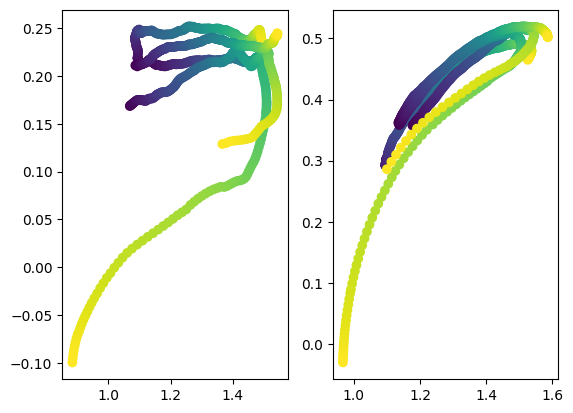

In [5]:
plt.subplot(121)
for i in range(len(trajs_p1)):
    plt.scatter(trajs_p1[i,:,0],trajs_p1[i,:,1], c=np.arange(cutoff-offset))

a = np.arange(cutoff-offset)
plt.subplot(122)
for i in range(len(trajs_p2)):
    plt.scatter(trajs_p2[i,:,0],trajs_p2[i,:,1], c=a)

In [6]:
#mat = spio.loadmat("data/LASA_dataset/Angle.mat", squeeze_me=True)
#train_data = np.array(list(mat['demos'])).transpose(0,2,1)

In [7]:
train_data = np.concatenate([trajs_p1, trajs_p2], axis=2)
train_data = (train_data  - np.mean(train_data, axis=(0,1))) / np.std(train_data, axis=(0,1))
data = Dataset(train_data, device=device)

In [8]:
params = {'batch_size': batch_size, 'shuffle': True}
dataloader = DataLoader(data, **params)
## optimization ##
lr = 0.001
weight_decay = 0.1

In [ ]:
dynamic = model.TanhStochasticDynamics(dim=4, device=device).to(device)
flow_h = create_flow_seq(dim=2, depth=4).to(device)
flow_r = create_flow_seq(dim=2, depth=4).to(device)
iflow = model.ContinuousDynamicFlow(flow_h, flow_r, dynamics=dynamic, dim=4, device=device).to(device)

params = list(flow_h.parameters()) + list(flow_r.parameters()) + list(dynamic.parameters())
optimizer = optim.Adam(params, lr = lr, weight_decay= weight_decay)

In [ ]:
x,y = next(iter(dataloader))

In [ ]:
y0 = x
y1 = y[0]
step = y[1][0]
yN = y[2]
t = y[3]

In [ ]:
y0[:,:2].shape

In [ ]:
x_0, log_det_J_x0 = iflow(y0)

In [ ]:
x_0.shape

In [ ]:
def goto_dynamics_train(iflow, x, y):
    ## Separate Data ##
    y0 = x
    y1 = y[0]
    step = y[1][0]
    yN = y[2]
    t = y[3]
    ## Evolve dynamics backwards ##
    x_0, log_det_J_x0 = iflow(y0)
    x_1, log_det_J_x1 = iflow(y1)

    p_x0_x1 = iflow.dynamics.conditional_distribution(x_1, T=step, reverse=True)
    log_p_z0 = p_x0_x1.log_prob(x_0)
    loss_trj = log_p_z0 + log_det_J_x0.squeeze()

    ########## Last step #############
    yN = yN[:1,:]
    x_n, log_det_J_xn = iflow(yN)
    log_p_xn = iflow.dynamics.compute_stable_log_px(x_n)
    loss_end = log_p_xn + log_det_J_xn.squeeze()

    #### Complete Loss is composed between the stable loss and the trajectory loss
    loss_total = torch.mean(loss_trj) + torch.mean(loss_end)
    return -loss_total

for i in range(nr_epochs):
    # Training
    for local_x, local_y in dataloader:
        dataloader.dataset.set_step()
        optimizer.zero_grad()
        loss = goto_dynamics_train(iflow, local_x, local_y)
        loss.backward(retain_graph=True)
        optimizer.step()

    ## Validation ##
    if i%1 == 0:
        with torch.no_grad():
            iflow.eval()

            visualize_2d_generated_trj(train_data, iflow, device, fig_number=2)
            visualize_latent_distribution(train_data, iflow, device, fig_number=1)
            #visualize_vector_field(train_data, iflow, device, fig_number=3)
            iros_evaluation(train_data, iflow, device)

            ## Prepare Data ##
            step = 20
            trj = train_data[0]
            trj_x0 = to_torch(trj[:-step,:], device)
            trj_x1 = to_torch(trj[step:,:], device)
            #log_likelihood(trj_x0, trj_x1, step, iflow, device)
            #print('The Variance of the latent dynamics are: {}'.format(torch.exp(iflow.dynamics.log_var)))
            #print('The Velocity of the latent dynamics are: {}'.format(iflow.dynamics.Kv[0,0]))

In [ ]:
iflow.flow_forward(local_x)